In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.stats.multitest import multipletests

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# drop hetarb - only 2 data points
flamog = flamog[flamog.species!='HETARB']
# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

Unnamed: 0 species  plant        date  total_branch_mass  total_leaf_mass  \
0           1  ARCDEN      1  2022-08-10             20.347           19.505   
1           2  ARCDEN      1  2022-08-10             20.347           19.505   
2           3  ARCDEN      1  2022-08-10             20.347           19.505   
3           4  ARCDEN      1  2022-08-10             20.347           19.505   
4           5  ARCDEN      1  2022-08-10             20.347           19.505   

   stem_mass_ratio  leaf_mass_ratio   leaf_lfm  thickness  ...  wet_mass  \
0         0.510564         0.489436  251.06912      0.514  ...     1.151   
1         0.510564         0.489436  251.06912      0.514  ...     1.151   
2         0.510564         0.489436  251.06912      0.514  ...     1.151   
3         0.510564         0.489436  251.06912      0.514  ...     1.151   
4         0.510564         0.489436  251.06912      0.514  ...     1.151   

   dry_mass   gdw_gfw  dw_flam_sample  ww_flam_sample  branch_volume  \
0    0.3683  0.242414        1.291195        4.035205        1082.04   
1    0.3683  0.242414        1.429372        4.467028        1370.20   
2    0.3683  0.242414        1.283923        4.012477         682.04   
3    0.3683  0.242414        1.283923        4.012477        1262.25   
4    0.3683  0.242414        0.811215        2.535185         819.00   

   branching  sample_density  dw_sppdev  plant_id  
0   0.416667        0.004923   0.923122  1_ARCDEN  
1   0.322581        0.004303   1.348152  1_ARCDEN  
2   0.294118        0.007766   0.900752  1_ARCDEN  
3   0.466667        0.004196   0.900752  1_ARCDEN  
4   0.500000        0.004086  -0.553297  1_ARCDEN  

[5 rows x 81 columns]

In [3]:
flamog.species.value_counts()

species
ERIKAR    37
SALLEU    36
CEAGRI    29
SALAPI    22
MALLAU    20
ARTCAL    13
ARCDEN     8
Name: count, dtype: int64

# Examine Correlation & Structure in Num. Var's

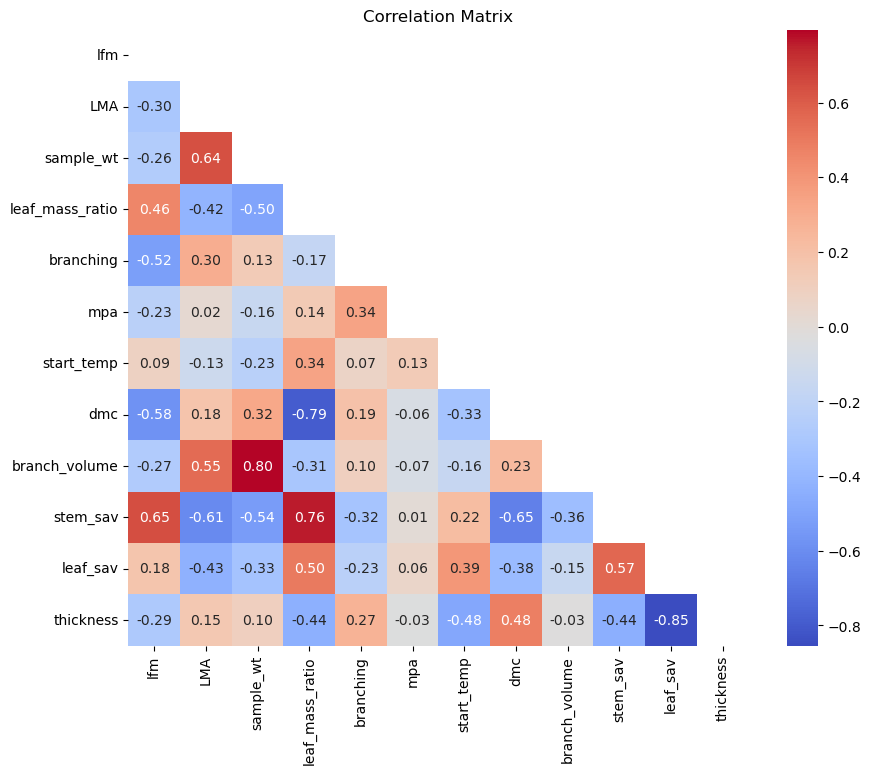

In [4]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

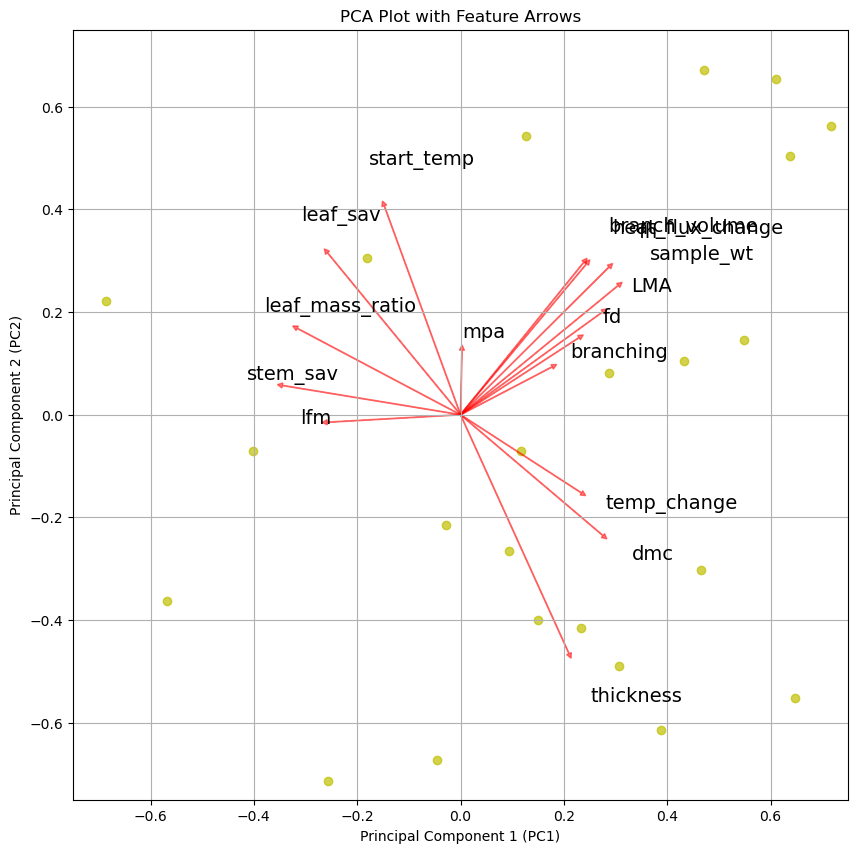

In [5]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [6]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use #+ ['species']
print(cols_use)

165
158
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']


## FD

In [7]:
y='fd'
df=flam

## examine each variable's LM within species groups

print if near significant

In [8]:
pthresh=0.15

for var in cols_use:
    print('\n\n', var)
    formula = y + '~' + var
    for spec in flam.species.unique():
        flami=flam[flam.species==spec]
        model = smf.ols(formula, data=flami)
        results = model.fit(reml=False)
        if results.pvalues[1] < pthresh:
            print(spec)
            print(results.params[1], results.pvalues[1])
            #sns.regplot(x= flami.lfm, y= flami.fh);



 lfm
ERIKAR
0.313431560132482 0.06575165563054747
SALAPI
-0.45258586374363935 0.01989969228280508
SALLEU
-1.4105899137774682 0.12373444498368424


 LMA
ARTCAL
0.29725284114900097 1.1632871019401268e-05
SALAPI
-0.5464680324879214 0.03066405827023524
SALLEU
1.419192647446379 0.054976392982966374


 sample_wt
MALLAU
0.7964943270912596 0.010222769244982433
SALLEU
1.5829419383375722 0.0001928654508157914


 leaf_mass_ratio
SALLEU
-0.6194270665845991 0.06034073676757304


 branching
SALAPI
0.5064895128947168 0.006461157216686809
SALLEU
0.42272665000299653 0.042236665501726035


 mpa
ARCDEN
0.7646446484744724 0.1273445368589499


 start_temp
SALAPI
-0.432109083982546 0.03293209949861804


 dmc
MALLAU
1.7400288157521582 0.023704135358535872
SALLEU
0.36147158223826553 0.046536991771376796


 branch_volume
SALLEU
1.1401166339950752 0.016934538070923457


 stem_sav
SALAPI
1.8835680353054454 0.04006693505036602
SALLEU
-2.9578590758938517 0.1300833849660778


 leaf_sav
ERIKAR
-0.20334418115474248

## examine each variables significance and ranking by AIC outside in Mixed LM structure
(tests each independently and reports together)

In [34]:
yvar=y
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               mpa  436.873240 -0.030688  7.437746e-01     True
1        start_temp  436.079075 -0.065230  5.218623e-01     True
2         thickness  435.387128  0.080096  5.179140e-01     True
3          leaf_sav  435.007152 -0.100602  3.998897e-01     True
4               LMA  434.967441  0.233946  9.034159e-02     True
5   leaf_mass_ratio  434.235530 -0.190051  5.249440e-01    False
6               lfm  433.629983 -0.229844  1.616765e-01    False
7          stem_sav  433.615000 -0.317586  6.588064e-02    False
8         branching  433.207184  0.180716  5.759355e-02    False
9     branch_volume  425.968222  0.336634  8.489578e-04    False
10              dmc  424.962442  0.402439  3.168880e-04    False
11        sample_wt  412.060412  0.487190  4.197782e-09    False


### test correlation of top predictors
`thickness` and `leaf_sav` are too correlated

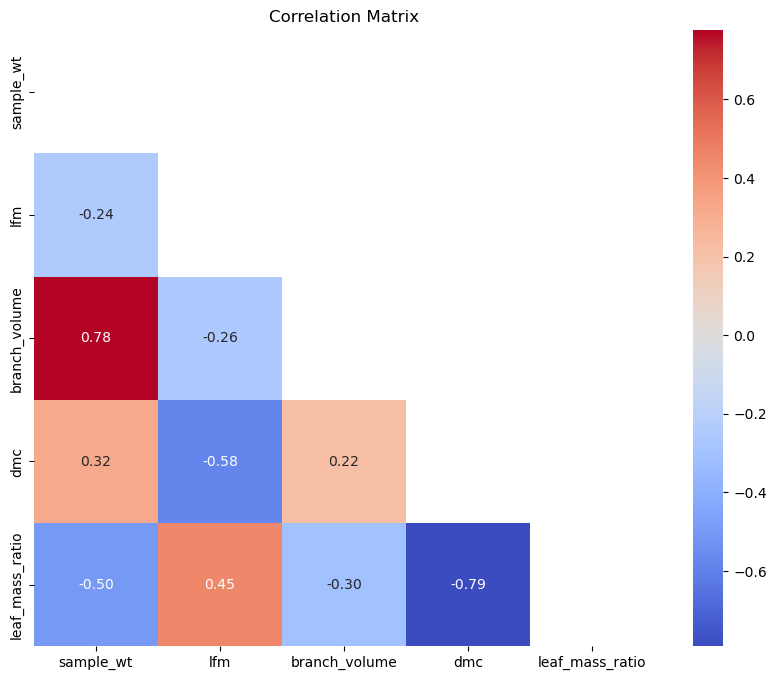

In [33]:
corrplot(flam, ['sample_wt', 'lfm', 'branch_volume', 'dmc', 'leaf_mass_ratio'])

In [ ]:
# fd ~ lfm*sample_wt + dmc + branch_volume
# fd ~ lfm*sample_wt + leaf_mass_ratio + dmc + branch_volume
# fd ~ lfm*sample_wt + dmc
# fd ~ sample_wt*dmc + lfm*sample_wt + leaf_mass_ratio + branch_volume
# fd ~ lfm*sample_wt + leaf_mass_ratio + mpa + dmc + branch_volume
# fd ~ sample_wt*dmc + lfm*sample_wt + branch_volume
# fd ~ lfm*sample_wt + mpa + dmc + branch_volume
# fd ~ lfm*sample_wt + dmc + branch_volume + thickness
# fd ~ lfm*sample_wt + branching + dmc + branch_volume
# fd ~ lfm*sample_wt + dmc + branch_volume + leaf_sav
# fd ~ lfm*sample_wt + branch_volume + leaf_sav
# fd ~ sample_wt*dmc + lfm*sample_wt + leaf_mass_ratio + mpa + branch_volume
# fd ~ lfm*sample_wt + leaf_mass_ratio + dmc
# fd ~ lfm*sample_wt + leaf_mass_ratio + dmc + branch_volume + leaf_sav
# fd ~ lfm*sample_wt + start_temp + dmc + branch_volume
# fd ~ lfm*sample_wt + LMA + dmc + branch_volume
# fd ~ lfm*sample_wt + leaf_mass_ratio + dmc + branch_volume + thickness
# fd ~ lfm*sample_wt + dmc + thickness
# fd ~ lfm*sample_wt + leaf_mass_ratio + dmc + branch_volume + stem_sav
# fd ~ lfm*sample_wt + branch_volume + thickness

## examine candidate formula(s) for publication

Joe’s Model: 400.8
- `fd ~ dmc*sample_wt`
  
My Model: 394.4
- `fd ~ lfm*sample_wt + dmc + branch_volume + leaf_mass_ratio`
- lfm appears in all models, dmc appears in nearly all models *coefs are sensible, coef in interaction `lfm*sample_wt` is sensible*
- adding `leaf_mass_ratio` does not foul sensible patterns w other vars and has a sensible coef
- adding in the following variables does not tangibly add to the model `mpa`,`thickness`, `leaf_sav`,`start_temp`,`stem_sav`
- **CORRELATION ISSUES? VIF is ok: `sample_wt` & `branch_volume`; `dmc` & `leaf_mass_ratio`**

In [35]:
formula = y + '~ lfm*sample_wt + dmc + branch_volume + leaf_mass_ratio'

cols_list = ['sample_wt', 'lfm', 'branch_volume', 'dmc', 'leaf_mass_ratio']

# check VIF
X = flam[cols_list] 
X['int1'] = flam.sample_wt*flam.lfm
print('VIFmax:', max([variance_inflation_factor(X.values, i) for i in range(len(X.columns))]))

# model
model = smf.mixedlm(formula, data=flam, groups=flam["species"], re_formula='1', vc_formula={'C(species):C(plant_id)': '0 + C(plant_id)'})
results = model.fit(reml=False)

# report
plot_ols_coefficients(results)
print('AIC:', results.aic)
# print adjusted pvals
print([i for i in multipletests(results.pvalues, method='bonferroni')[1]])
results.summary()

VIFmax: 3.535307784208698
AIC: 394.66762812635716
[1.0, 0.16507205566738878, 8.618048056635585e-05, 8.133741691112387e-05, 0.012654989947430856, 0.39756090951809947, 0.5641977124458066, nan, nan]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5628   
Min. group size:        8           Log-Likelihood:         -187.3338
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.079    0.165 -0.476 0.634 -0.402  0.245
lfm                        -0.245    0.104 -2.359 0.018 -0.448 -0.041
sample_wt                   0.516    0.117  4.427 0.000  0.288  0.745
lfm:sample_wt              -0.514    0.116 -4.439 0.000 -0.741 -0.287
dmc                         0.408    0.128  3.193 0.001  0.158  0.658
branch_volume              -0.253    0.126 -2.012 0.044 -0.499 -0.007
leaf_mass_ratio             0.225    0.121  1.861 0.063 -0.012  0.463
Group Var                   0.153                                    
C(species):C(plant_id) Var  0.017                                    
=====================================================================

"""

## interpretation of candidate model

`fd ~ lfm*sample_wt + dmc + branch_volume + leaf_mass_ratio`

- FD increases with increasing ...
- FD increases with decreasing ...

Interpret/why ecol??

### within species patterns

- ...

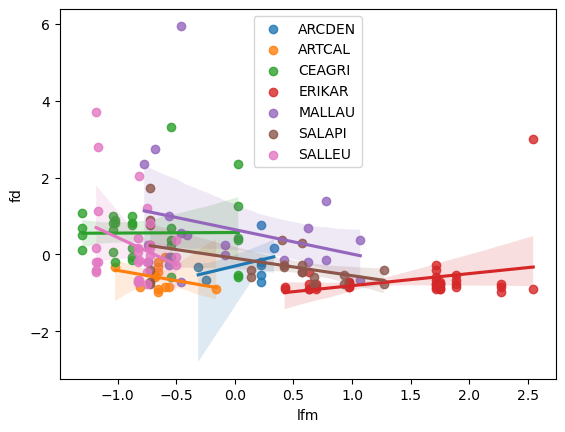

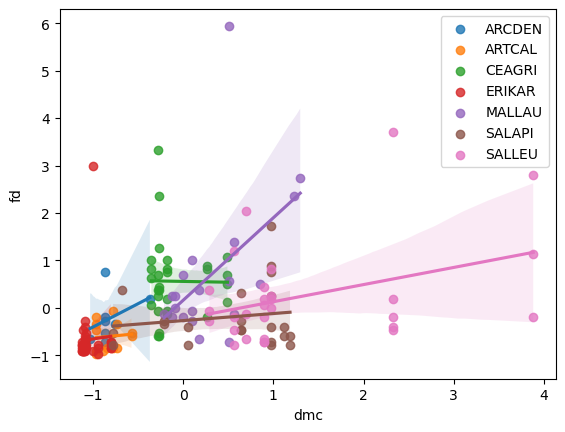

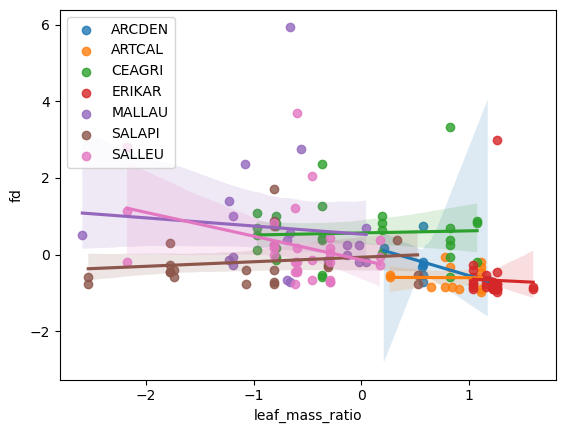

In [31]:
for col in cols_list:
    for spec in flam.species.unique():
        flami = flam[flam.species==spec]
        sns.regplot(x=col, y=y, data=flami, label=spec)#, ci=None, order=2)
    plt.legend()
    plt.show();

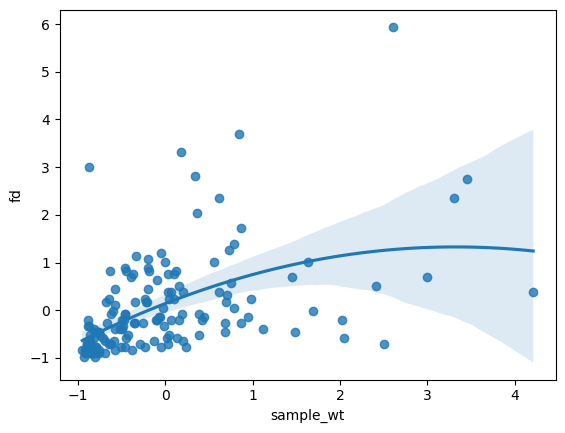

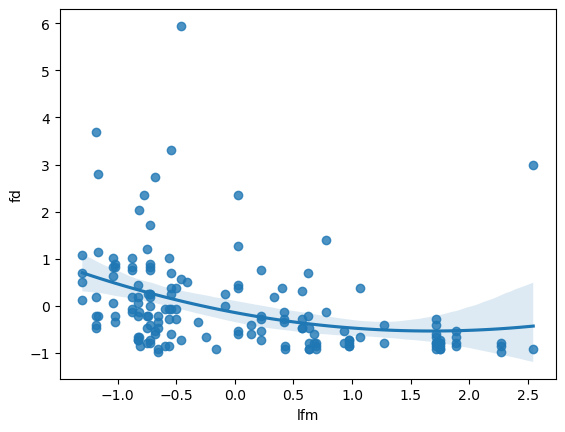

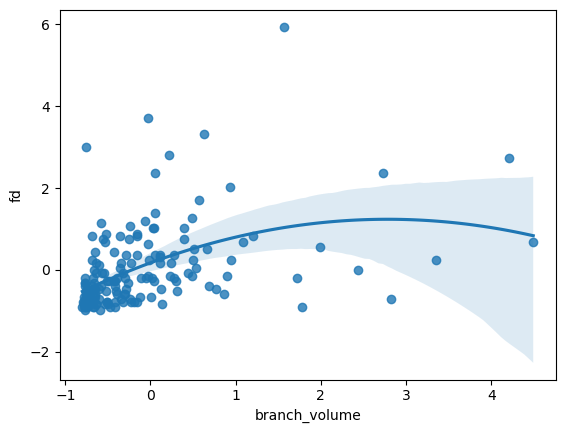

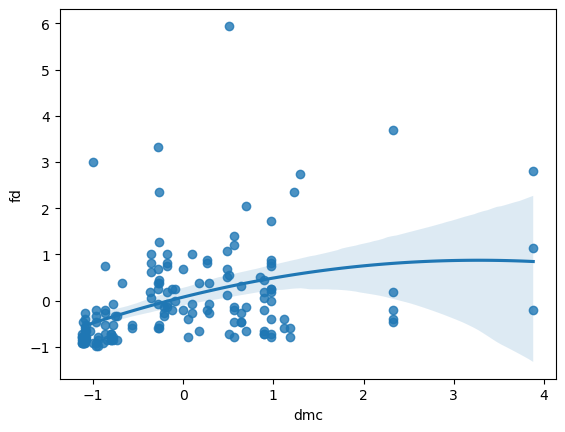

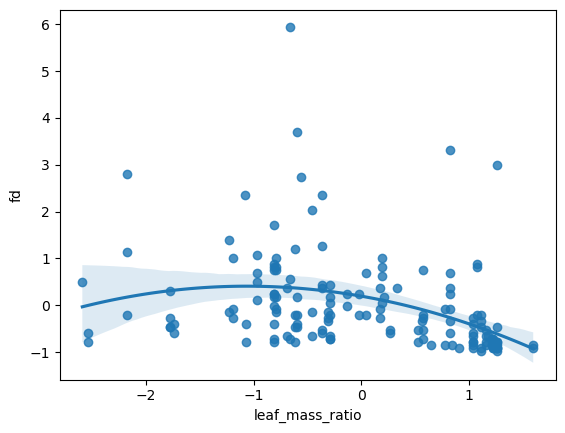

In [32]:
for col in cols_list:
    sns.regplot(x=col, y=y, data=flam, order=2)
    plt.show();